In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [71]:
from proj1_helpers import *
from validation_helpers import *
from plots import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [72]:
from implementations import *

## Do your thing crazy machine learning thing here :) ...

In [4]:
split_x, split_y, split_ids = separate(y, tX, ids)

In [5]:
selection = dataStatistics(split_x)

Statistics 
Type :
0
[0.26145747 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         1.         0.        ]
Statistics 
Type :
1
[0.09751883 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05859584 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.0

In [6]:
cleaned = removeNone(split_x, selection)



# Now we can either drop the lines with residual Nones or replace the Nones by the median value

In [7]:
cleaned_with_median = putMedianInsteadOfNone(cleaned)

cleaned_with_median_with_momentum = add_momentum_vector(cleaned_with_median)

In [8]:
dropped_x, dropped_y, dropped_ids = dropLineIfNone(cleaned, split_y, split_ids)


## At this point, the first values in each of the split data has a PRI_jet_num = 0, then 1 and so on. The data is clean and we can work with it.

## Generate predictions and save ouput in csv format for submission:

In [9]:
DATA_TEST_PATH = '../data/test.csv' 
y_donotUse, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [86]:
sigmoid(-20000)

0.0

In [88]:
#separate data with respect to column 24 and remove None
split_x_test, _, split_ids_test =  separate(y_donotUse, tX_test, ids_test)


split_x_cleaned_test = removeNone(split_x_test, dataStatistics(split_x_test))

#median instead of None
split_x_with_median = putMedianInsteadOfNone(split_x_cleaned_test)

split_x_with_median_with_momentum = add_momentum_vector(split_x_with_median)

#line dropped when None
#split_x_drop_lines, split_y_dropped_split_indexes_dropped = dropLineIfNone(split_x_cleaned_test, _, split_ids_test)

#degrees for polynomial feature expension
degrees = [1,2,3,4,5,6,7,8]

y_res = []

acc = []

plot_data_per_jetnum = []


for i in range(len(cleaned_with_median)):
    
    
    
    #training: chose either cross calidation or cross validation for logistic regression with regularization
    #w_star, d, accuracy, training_set, plot_data = crossValidation(cleaned_with_median[i], split_y[i], 0.98, degrees ,6)
    w_star, d, accuracy, training_set, plot_data = crossValidationForLogistic_reg_with_loss(cleaned_with_median[i], split_y[i], 0.9, degrees ,6)
    
    
    #polynomial feature expension and normalization using the training data
    mean = np.mean(build_poly(training_set,d), axis = 0)
    std = np.std(build_poly(training_set,d), axis = 0)
    
      
    #put 1 if std = 0
    std = std + (std == 0)
    
    extended_and_normalized = (build_poly(split_x_with_median[i], d) - mean) / std
    
    #adding bias term
    bias = np.ones(shape=split_x_with_median[i].shape)          
    x_test_ready = np.c_[bias, extended_and_normalized]
    
    #prediction for least squares
    #y_res.append(predict_labels(w_star, x_test_ready))
    
    #prediction for logistic
    y_res.append(predict_labels_logistic(w_star, x_test_ready))
    


    acc.append(accuracy)
    plot_data_per_jetnum.append(plot_data)

print("Accuracy per jet nbr: \n")
print(acc)


Statistics 
Type :
0
[0.2605448 0.        0.        0.        1.        1.        1.
 0.        0.        0.        0.        0.        1.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.        1.        1.        1.        1.
 1.        0.       ]
Statistics 
Type :
1
[0.09834149 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05881481 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.06376737 0.         0.     

lambda=0.00100,degree=6, gamma=0.41000, Training Loss=5791345.563441181, Testing Loss=5177091.023474201
lambda=0.00100,degree=6, gamma=0.61000, Training Loss=11940502.521635419, Testing Loss=11332272.625423754
lambda=0.00100,degree=6, gamma=0.81000, Training Loss=20469319.622462776, Testing Loss=19859382.452906035
lambda=0.00100,degree=7, gamma=0.01000, Training Loss=801359.2957701853, Testing Loss=93702.7331193503
lambda=0.00100,degree=7, gamma=0.21000, Training Loss=3740133.3005526112, Testing Loss=3033020.9066320756
lambda=0.00100,degree=7, gamma=0.41000, Training Loss=11928502.018499773, Testing Loss=11221078.768395307
lambda=0.00100,degree=7, gamma=0.61000, Training Loss=25075726.29760448, Testing Loss=24368199.427972436
lambda=0.00100,degree=7, gamma=0.81000, Training Loss=43373961.31401699, Testing Loss=42666434.44438495
lambda=0.00100,degree=8, gamma=0.01000, Training Loss=2164396.054223992, Testing Loss=235363.32356038812
lambda=0.00100,degree=8, gamma=0.21000, Training Loss=1

lambda=0.00000,degree=6, gamma=0.21000, Training Loss=694009.6188368468, Testing Loss=76741.4708814959
lambda=0.00000,degree=6, gamma=0.41000, Training Loss=660067.7442140973, Testing Loss=76133.39645927867
lambda=0.00000,degree=6, gamma=0.61000, Training Loss=661597.5244608548, Testing Loss=80723.86588981305
lambda=0.00000,degree=6, gamma=0.81000, Training Loss=667191.2747729281, Testing Loss=88337.79457864654
lambda=0.00000,degree=7, gamma=0.01000, Training Loss=1386608.285179403, Testing Loss=158199.79205230498
lambda=0.00000,degree=7, gamma=0.21000, Training Loss=850477.0774367261, Testing Loss=97203.37524116134
lambda=0.00000,degree=7, gamma=0.41000, Training Loss=841892.6289509726, Testing Loss=97009.13882412722
lambda=0.00000,degree=7, gamma=0.61000, Training Loss=842091.9385570429, Testing Loss=98658.93809184164
lambda=0.00000,degree=7, gamma=0.81000, Training Loss=844416.2828391505, Testing Loss=103168.8919446091
lambda=0.00000,degree=8, gamma=0.01000, Training Loss=1390997.21

lambda=0.00200,degree=6, gamma=0.01000, Training Loss=1767397.9800006058, Testing Loss=207001.90102980504
lambda=0.00200,degree=6, gamma=0.21000, Training Loss=2877345.5898449225, Testing Loss=2256680.5129934335
lambda=0.00200,degree=6, gamma=0.41000, Training Loss=8832799.717914235, Testing Loss=8245628.089219003
lambda=0.00200,degree=6, gamma=0.61000, Training Loss=18302701.725287933, Testing Loss=17721034.210825574
lambda=0.00200,degree=6, gamma=0.81000, Training Loss=30562371.77667205, Testing Loss=29986385.599416126
lambda=0.00200,degree=7, gamma=0.01000, Training Loss=1387687.6524912321, Testing Loss=159341.0899412715
lambda=0.00200,degree=7, gamma=0.21000, Training Loss=2254626.230100647, Testing Loss=1508231.218595647
lambda=0.00200,degree=7, gamma=0.41000, Training Loss=6123584.226839415, Testing Loss=5408198.876651007
lambda=0.00200,degree=7, gamma=0.61000, Training Loss=12416253.18920031, Testing Loss=11711782.105393786
lambda=0.00200,degree=7, gamma=0.81000, Training Loss=2

lambda=0.00100,degree=5, gamma=0.81000, Training Loss=11987465.991472825, Testing Loss=11446249.268698948
lambda=0.00100,degree=6, gamma=0.01000, Training Loss=818199.6886127052, Testing Loss=102371.61793047684
lambda=0.00100,degree=6, gamma=0.21000, Training Loss=1248148.6872603195, Testing Loss=793611.1109647176
lambda=0.00100,degree=6, gamma=0.41000, Training Loss=3298550.5002353713, Testing Loss=2848877.9166710274
lambda=0.00100,degree=6, gamma=0.61000, Training Loss=6657634.626302415, Testing Loss=6212310.951564091
lambda=0.00100,degree=6, gamma=0.81000, Training Loss=11320639.804462887, Testing Loss=10877532.21564814
lambda=0.00100,degree=7, gamma=0.01000, Training Loss=705903.301886114, Testing Loss=81503.3519023161
lambda=0.00100,degree=7, gamma=0.21000, Training Loss=1245334.8328339132, Testing Loss=681700.963513697
lambda=0.00100,degree=7, gamma=0.41000, Training Loss=2948157.838265796, Testing Loss=2389517.2957917363
lambda=0.00100,degree=7, gamma=0.61000, Training Loss=5748

lambda=0.00000,degree=5, gamma=0.61000, Training Loss=255917.7866133711, Testing Loss=29505.799675521866
lambda=0.00000,degree=5, gamma=0.81000, Training Loss=250001.79517402803, Testing Loss=29716.01659617128
lambda=0.00000,degree=6, gamma=0.01000, Training Loss=792275.2230947935, Testing Loss=88040.93393363371
lambda=0.00000,degree=6, gamma=0.21000, Training Loss=459177.82131484034, Testing Loss=52744.16730388376
lambda=0.00000,degree=6, gamma=0.41000, Training Loss=210518.22916226654, Testing Loss=22455.450850050882
lambda=0.00000,degree=6, gamma=0.61000, Training Loss=208930.25005891552, Testing Loss=22778.4854263879
lambda=0.00000,degree=6, gamma=0.81000, Training Loss=202765.7979251206, Testing Loss=22580.269733828893
lambda=0.00000,degree=7, gamma=0.01000, Training Loss=390345.29247438256, Testing Loss=42575.078310567646
lambda=0.00000,degree=7, gamma=0.21000, Training Loss=336509.19251614576, Testing Loss=37071.036064968
lambda=0.00000,degree=7, gamma=0.41000, Training Loss=459

lambda=0.00200,degree=5, gamma=0.41000, Training Loss=885951.2432447829, Testing Loss=703284.9614761752
lambda=0.00200,degree=5, gamma=0.61000, Training Loss=1721807.7599913112, Testing Loss=1408771.3004697105
lambda=0.00200,degree=5, gamma=0.81000, Training Loss=2752024.149686138, Testing Loss=2441267.101406548
lambda=0.00200,degree=6, gamma=0.01000, Training Loss=798396.932419888, Testing Loss=88562.41156649348
lambda=0.00200,degree=6, gamma=0.21000, Training Loss=532060.5566251406, Testing Loss=176134.05480864114
lambda=0.00200,degree=6, gamma=0.41000, Training Loss=817774.5232523663, Testing Loss=561554.3363319377
lambda=0.00200,degree=6, gamma=0.61000, Training Loss=1517650.411242994, Testing Loss=1232293.9661737646
lambda=0.00200,degree=6, gamma=0.81000, Training Loss=2310236.0075162915, Testing Loss=2067641.0560561102
lambda=0.00200,degree=7, gamma=0.01000, Training Loss=403698.9236314634, Testing Loss=44555.60363713422
lambda=0.00200,degree=7, gamma=0.21000, Training Loss=37029

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

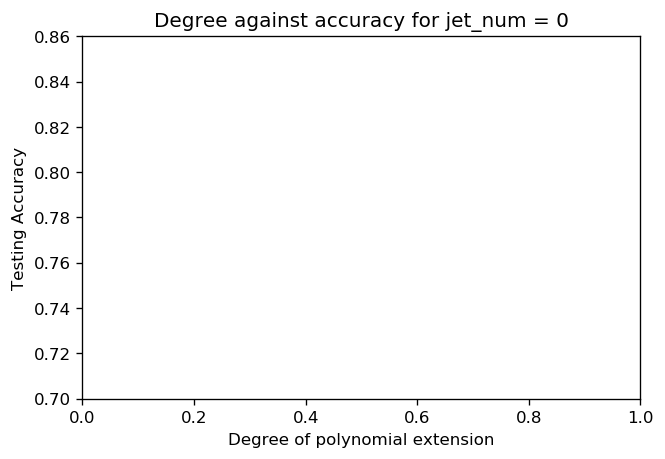

In [54]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for i in range(len(plot_data_per_jetnum)):
    jet_num = plot_data_per_jetnum[i]



    X = np.array([x[0] for x in jet_num])
    Y = np.array([x[1] for x in jet_num])
    Z = np.array([x[3] for x in jet_num])
    

    plt.figure(dpi=120)
    plt.title('Degree against accuracy for jet_num = %d' %i)
    plt.xlabel('Degree of polynomial extension')
    plt.ylabel('Testing Accuracy')

    axes = plt.gca()
    axes.set_ylim([0.7,0.86])

    plt.stem(Y, Z, use_line_collection=True, label="hello")
    plt.savefig("cross_with_momentum_"+str(i))
    plt.show()


In [ ]:
OUTPUT_PATH = '../data/submission.csv'
#reassemble the data for the submission
y_pred = put_together(y_res, split_ids_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)